<a href="https://colab.research.google.com/github/QianqianLiu/NSF_Cybertraining/blob/main/pylibs_3_database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3 work with database in pylibs**

**purpose**: a universal method in organizing and archiving your data

### **some data-intensive problems**:
Assuming that we have a database of world population (7-8 billion) including all kinds of information about name, age, gender, nationality, height, weight, color, etc, how can we filter the database to get all the data you want from this data, such as
  * all the people with age between 15 and 20, or
  * all the people with age=[15, 20], gender=female, nationality=US, color=white, weight=120 lb, ...  ?


There are many other similar problems that require us to work with very large datasets:` numerical modeling results (~TB), satellite data (~PB), DNA sequence data, ....`.  Thus,
  1. how can we organize our data, and efficiently find all the data we needed?
  2. If you are the adminstrator of the database, how can you meet all the inquiries from all the users?  

In [ ]:
#install and import pylibs
!pip install pylibs-ocean[shapefile,eof]
from pylib import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.6/395.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.1 MB/s eta 0:00:00


In [ ]:
#download training dataset
!rm *.txt *.zip *.nc *.csv *.dbf *.prj *sh? *.npz  #clean existing data first
urlsave('https://docs.google.com/uc?export=download&id=1o6m70CuQr-vcTLLTc9EY_0cb3L_qkQQV','cybertrainingdata_2024.zip')
!unzip cybertrainingdata_2024.zip

rm: cannot remove '*.txt': No such file or directory
rm: cannot remove '*.zip': No such file or directory
rm: cannot remove '*.nc': No such file or directory
rm: cannot remove '*.csv': No such file or directory
rm: cannot remove '*.dbf': No such file or directory
rm: cannot remove '*.prj': No such file or directory
rm: cannot remove '*sh?': No such file or directory
rm: cannot remove '*.npz': No such file or directory
Archive:  cybertrainingdata_2024.zip
  inflating: elev_model.npz          
  inflating: GEBCO.nc                
  inflating: JMSMH_10122020.csv      
  inflating: noaa_elev.npz           
  inflating: SFBay.dbf               
  inflating: SFBay.prj               
  inflating: SFBay.shp               
  inflating: SFBay.shx               
  inflating: SFBay_temp.npz          
  inflating: SFBayWQ.npz             
  inflating: USGS_flow_data.txt      
  inflating: USGS_flow.txt           
  inflating: YRK005.40_7312023.csv   


## **3.1 data container**
In pylibs, we save our data (string, single int/float, array, or object) as the attributes of an object (zdata class).
* **`zdata`**: an empty class with its attributs to be used to store data
* **`savez`**: save zdata as a numpy dataset (*.npz format)
* **`loadz`**: load zdata (or use generic function `read`)

In [ ]:
#Example 3.1
#usage of zdata,savez,and loadz

#get a data capsule
ds=zdata()

#save some data into the capsule
x=arange(0,20,0.1)
ds.x=x
ds.y=(x-10)**2/10
ds.z=abs(x-10)*sin(3*x)
ds.a=10
ds.b='zdata demo'
ds.c=[3,'cat','dog',100]

ds.note='this is my note'

#save data to dist
ds.save('demo')  #same as savez('demo',ds)

#show data
!ls  #this is linux command

cybertrainingdata_2024.zip  JMSMH_10122020.csv	SFBay.prj	SFBayWQ.npz
demo.npz		    noaa_elev.npz	SFBay.shp	USGS_flow_data.txt
elev_model.npz		    sample_data		SFBay.shx	USGS_flow.txt
GEBCO.nc		    SFBay.dbf		SFBay_temp.npz	YRK005.40_7312023.csv


In [ ]:
# load data
C=read('demo.npz') #a generic function
# S=loadz('demo.npz') #same function

# thiand shows data summary
C.INFO

['a   : 10, int',
 'b   : "zdata demo", string',
 'c   : list(4,)',
 'note: "this is my note", string',
 'x   : array(200,), float64',
 'y   : array(200,), float64',
 'z   : array(200,), float64']

Text(0.5, 1.0, 'zdata demo')

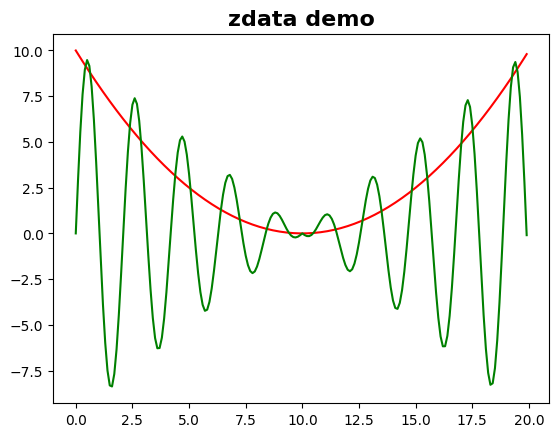

In [ ]:
#simple plot of demo data
plot(C.x,C.y,'r-')
plot(C.x,C.z,'g-')
title(C.b,fontsize=16,fontweight='bold')

##  **3.2. process data, and creat a database**

* **an universal format for creating database**
    * data values are saved as 1D array
    * associated the 1D data array with different information (e.g. depth, location, variable name, etc.) also arranged as 1D arrays

* In theory, most of data, no matter how complicated they are, they can be organized in this universal format.

* With this format, we can create filter according to our needs to precisely acquire the data we want.

* Another beauty of this universal format is that it can be naturally extendable to multiple databases for the same type of data (can be as large as you want in this case). Most importantly, a filter can apply to all databases.

In [ ]:
#download elevation data

#station information
stations=[8658163, 8658120]
stanames=['Wrightsville Beach, NC', 'Wilmington, NC']
url0='https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?product=hourly_height&application=NOS.COOPS.TAC.WL&time_zone=GMT&units=metric&format=csv&datum=msl&begin_date=20230101&end_date=20230531&station='

#download data
for station in stations:
  url=url0+str(station)  #get url for stations
  urlsave(url,str(station)+'.csv') #download noaa data


In [ ]:
#check files information
!ls   #show downloaded files

!head -n 10 8658120.csv  #check files

8658120.csv		    GEBCO.nc		SFBay.prj	USGS_flow_data.txt
8658163.csv		    JMSMH_10122020.csv	SFBay.shp	USGS_flow.txt
cybertrainingdata_2024.zip  noaa_elev.npz	SFBay.shx	YRK005.40_7312023.csv
demo.npz		    sample_data		SFBay_temp.npz
elev_model.npz		    SFBay.dbf		SFBayWQ.npz
Date Time, Water Level, Sigma, I, L 
2023-01-01 00:00,0.064,0.004,0,0
2023-01-01 01:00,-0.200,0.006,0,0
2023-01-01 02:00,-0.426,0.006,0,0
2023-01-01 03:00,-0.636,0.007,0,0
2023-01-01 04:00,-0.791,0.004,0,0
2023-01-01 05:00,-0.719,0.003,0,0
2023-01-01 06:00,-0.369,0.006,0,0
2023-01-01 07:00,0.060,0.005,0,0
2023-01-01 08:00,0.380,0.003,0,0


In [ ]:
#Example of creating database
C=zdata(); C.time=[]; C.elev=[]; C.station=[]   #empty lists to add data
for station in stations:
  #---------------------------------------------------------------
  #method 1: parse each line
  #---------------------------------------------------------------
  # fid=open(str(station)+'.csv') #open file
  # lines=fid.readlines()         #read all line
  # fid.close()                   #close file
  # for i,line in enumerate(lines):
  #   if i==0: continue #skip header
  #   line_parse=line.split(',')  #split line
  #   time=datestr2num(line_parse[0]) #convert time string
  #   elev=float(line_parse[1])       #convert elev data string to number
  #   C.time.append(time)  #save data
  #   C.elev.append(elev)  #save data
  #   C.station.append(station) #save data
  #---------------------------------------------------------------

  #---------------------------------------------------------------
  #method 2: efficient/concise way in reading data
  #---------------------------------------------------------------
  data=array([i.split(',')[:2] for i in open(str(station)+'.csv').readlines()[1:]])
  C.time.extend(datestr2num(data[:,0]))     #convert time string to datanum
  C.elev.extend(data[:,1].astype('float'))  #convert data string to numbers
  C.station.extend(tile(station,len(data))) #save station attributes for each data
  #---------------------------------------------------------------

#save data into a database file
C.time=array(C.time); C.elev=array(C.elev); C.station=array(C.station) #convert to numpy array
C.staname=dict(zip(stations,stanames)) #create a dict to save space
#can add other attributes (e.g. lon & lat)
C.save('elev')

In [ ]:
#ways to inquire database information
# !ls  #check file

C=read('elev.npz')  #load database

C.INFO  #check database information
# unique(C.station)  #show unique station
# print(num2date(C.time.min()),num2date(C.time.max())) #check time range
# C.staname

['elev  : array(7248,), float64',
 'staname: dict(2,)',
 'station: array(7248,), int64',
 'time  : array(7248,), float64']

## **Excercise 2: create database**

File `JMSMH_10122020.csv` is dataflow measured in [James River](http://vecos.vims.edu/SegmentDetail.aspx?param=JMSMH&program=DFLO), VA. Process this dataset, and create a database by saving variables of `temperature, salinity， DO, pH` with attributes with`time, lon, lat, var`. Then, read the database you created, and checked the variables you saved.

After you finish the above tasks, think about how you find out the maximum values of different variables (no need to finish this taks now, just have some thought on it).


In [ ]:
#Type your answer 2 here

## **3.3 create filters: acquire data form database**

### **3.3.1 access the numpy values**

In [ ]:
a=arange(10)
a

#Question: how can we get values [1,7,9] out of numpy array "a"?

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
#method 1
a[1],a[7],a[9]

(1, 7, 9)

In [ ]:
#method 2
ind=array([1,7,9])
a[ind]

array([1, 7, 9])

In [ ]:
#method 3
fp=array([False,True,False,False,False,False,False,True,False,True])
# a[fp]

nonzero(fp)[0]

array([1, 7, 9])

In [ ]:
# a=arange(100).reshape([10,10])*10

# # 20,440,870
# a[0,2],a[4,4],a[8,7]

# ind1=array([0,4,8])
# ind2=array([2,4,7])
# a[ind1,ind2]

### how can we construct the filter
  * it is an odd number
  * can be smaller than 2, or larger than 6



In [ ]:
fp=(a%2==1)*((a<2)|(a>6))
fp
a[fp]

array([1, 7, 9])

## **excercise**

`a=arange(1000)`

find out all the numbers meeting the following conditions:
  * odd number
  * multiple of 31
  * not a multiple of 3 and 7
  * the 10th place is 1 (e.g. 215)

In [ ]:
#your anser here
a=arange(1000)

fp=(a%2==1)*(a%31==0)*(a%3!=0)*(a%7!=0)*(floor(a/10)%10==1)
a[fp]

array([713])

### **3.3.2 work with noaa water level database**

Text(0.5, 1.0, 'water level at Wrightsville Beach, NC')

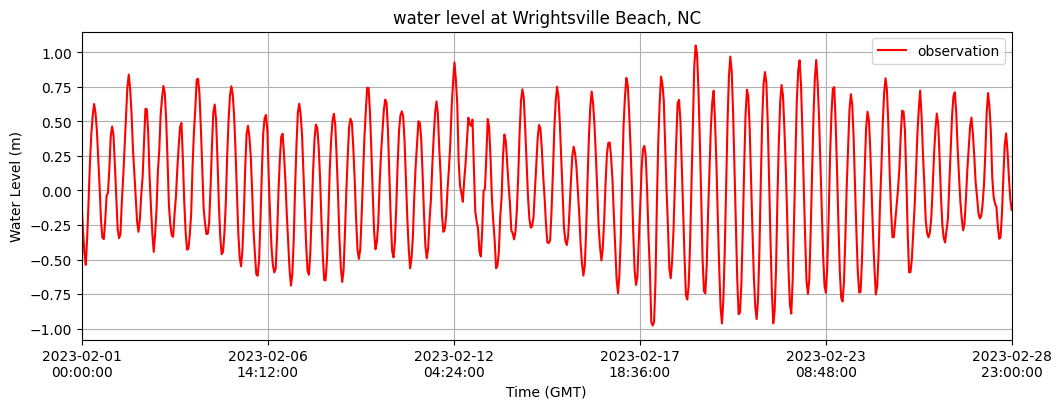

In [ ]:
C=read('elev.npz')

#create filters
# fp=C.station==8658163
# sn=array([C.staname[i] for i in C.station]); fp=sn=='Wrightsville Beach, NC'  #get all data by station name
fp=(C.station==8658163)*(C.time>=datenum(2023,2,1))*(C.time<datenum(2023,3,1)) #get data in certain time range

#get data
oti=C.time[fp]; oyi=C.elev[fp]

#plot water level
figure(figsize=[12,4])
plot(oti,oyi,'r-')

#annotation for figures
add_xtick()
gca().xaxis.grid('on'); gca().yaxis.grid('on')
legend(['observation'])
xlabel('Time (GMT)'); ylabel('Water Level (m)')
title('water level at {}'.format(C.staname[8658163]))


In [ ]:
C.VINFO

['elev  : array(7248,), float64',
 'staname: dict(2,)',
 'station: array(7248,), int64',
 'time  : array(7248,), float64']

## **3.4 Water Quality Database in San Francisco Bay**

In [ ]:
#read database
fname='SFBayWQ.npz' #database name
C=read(fname)

#show database information
C.INFO
# unique(C.var)

['data  : array(1239859,), float64',
 'depth : array(1239859,), float64',
 'lat   : dict(61,)',
 'lon   : dict(61,)',
 'station: array(1239859,), float64',
 'time  : array(1239859,), float64',
 'units : dict(14,)',
 'var   : array(1239859,), <U8']

In [ ]:
#further inquiry about the database
print('Variable:', unique(C.var),'\n')
print('Station:', unique(C.station),'\n')
print('Time:', num2date(C.time.min()),',',num2date(C.time.max()),'\n')
C.units

Variable: ['DO' 'DO_cmpt' 'Ke' 'NH4' 'NO2' 'NO23' 'PO4' 'SPM' 'SPM_cmpt' 'SiO4'
 'chl' 'chl_cmpt' 'salt' 'temp'] 

Station: [  1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.   12.
  12.5  13.   14.   15.   16.   17.   18.   19.   20.   21.   22.   23.
  24.   24.5  25.   25.5  26.   26.5  27.   27.5  28.   28.5  29.   29.5
  30.   30.5  31.   31.5  32.   33.   33.5  34.   35.   36.  405.  407.
 411.  649.  650.  651.  652.  653.  654.  655.  657.  659.  662. ] 

Time: 1969-04-10 00:00:00+00:00 , 2021-08-31 09:00:00+00:00 



{'chl': 'ug/L',
 'chl_cmpt': 'ug/L',
 'DO': 'mg/L',
 'DO_cmpt': 'mg/L',
 'SPM': 'mg/L',
 'SPM_cmpt': 'mg/L',
 'Ke': '1/m',
 'salt': 'PSU',
 'temp': 'oC',
 'NO2': 'uM',
 'NO23': 'uM',
 'NH4': 'uM',
 'PO4': 'uM',
 'SiO4': 'uM'}

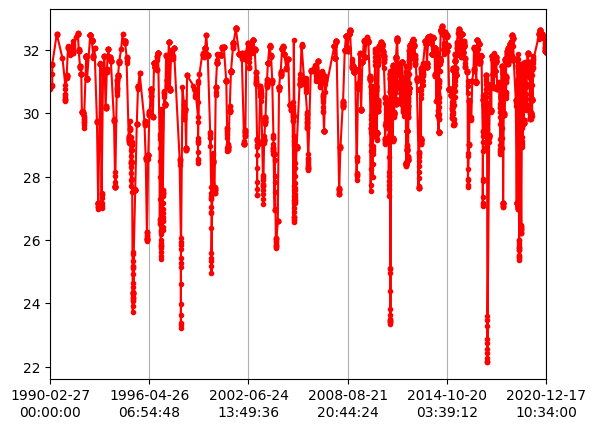

In [ ]:
#filter the database and plot
#-------------------------------------------------
#inputs
#-------------------------------------------------

#filter the database
# fp=(C.var=='salt')*(C.station==18)*(C.time>=datenum(1990,1,1))*(C.time<=datenum(2021,1,1))
fp=(C.var=='salt')*(C.station==18)*(C.time>=datenum(1990,1,1))*(C.time<=datenum(2021,1,1))*(C.depth>30)
# fp=(C.var=='DO')*(C.station==18)
oti=C.time[fp]; oyi=C.data[fp]

#sort the data with time
sind=argsort(oti); oti,oyi=oti[sind],oyi[sind]

#plot
plot(oti,oyi,'r.-')
add_xtick()

## **Excercise 3: filter database**

filter the database `SFBayWQ.npz`, and plot the time series of ammonium (NH4) concentration at station `9, 18, 657` form 2000 to 2020 together.

In [ ]:
#Type your answer 3 here